# Networking for Big Data
# Homework I

## Davide Aureli, Valerio Guarrasi and Andrea Marcocchia

### Import packages

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from heapq import *
import networkx as nx
from collections import defaultdict

#  PART 1

### Point 1: Write a script to generate an p-ER random graph

In [2]:
def p_ER(n, p):
    '''Function that returns the p-ER random graph, and need in input the number of nodes and the probability'''
    mat = np.zeros((n,n))
        
    for i in range(n):
        for j in range(i+1, n):
            add = np.random.binomial(1, p, 1)[0]
            if(add == 1):
                mat[i, j] = 1
                mat[j, i] = 1
    return mat

### Point 2: Write a script to generate a p-regular random graph

In [3]:
def r_regular(n, r):
    '''Function that generate a NxN matrix (adjency matrix for a p-regular graph) and need in input the number of nodes and the number of edges for each node'''
    n_mat = np.zeros((n, n))

    try:
        nr_mat = np.zeros((n*r, n*r)) # Generate an N*RxN*R matrix which is to be considered as N groups of R elements
        block_n = list(range(n)) # Number of nodes
        
        # Create a list of tuples where the first element are the R rows in the matrix and the second element
        # contains the N groups which the R rows can connect to
        l = []
        for i in range(len(block_n)-1):
            l.append( ( list(range(block_n[i]*r, block_n[i+1]*r) ), list(set(block_n)-set([i])) ) )
        l.append( ( list(range(block_n[n-1]*r, len(nr_mat))),  list(set(block_n)-set([n-1])) ) )
        
        # Which of the N groups can still be connected
        usable_groups = list(range(n))
        
        check = 0 # Count number of edge creation
        while check != int(n*r/2):
            
            # Pick two random Nodes
            pick_n_big_1 = np.random.choice(list(set(usable_groups))) 
            pick_n_big_2 = np.random.choice( list( set(l[pick_n_big_1][1]).intersection(set(usable_groups)) ) )
            
            # Pick an edge
            pick_n_small_1 = np.random.choice( l[pick_n_big_1][0] )
            pick_n_small_2 = np.random.choice( l[pick_n_big_2][0] )        
            
            # Put the 1 inside the N*R matrix
            nr_mat[ l[pick_n_big_1][0][ np.where(l[pick_n_big_1][0] == pick_n_small_1)[0][0] ],
                    l[pick_n_big_2][0][ np.where(l[pick_n_big_2][0] == pick_n_small_2)[0][0] ] ] = 1
                   
            nr_mat[ l[pick_n_big_2][0][ np.where(l[pick_n_big_2][0] == pick_n_small_2)[0][0]],
                    l[pick_n_big_1][0][ np.where(l[pick_n_big_1][0] == pick_n_small_1)[0][0] ] ] = 1
            
            # Update the l list deleting the useless Nodes and Edges
            del l[pick_n_big_1][0][ np.where(l[pick_n_big_1][0] == pick_n_small_1)[0][0] ]
            del l[pick_n_big_2][0][ np.where(l[pick_n_big_2][0] == pick_n_small_2)[0][0] ]
            
            del l[pick_n_big_1][1][ np.where(l[pick_n_big_1][1] == pick_n_big_2)[0][0] ]
            del l[pick_n_big_2][1][ np.where(l[pick_n_big_2][1] == pick_n_big_1)[0][0] ]
            
            # If a node has ended the useful Edges delete that node from the usable_groups
            if( len(l[pick_n_big_1][0]) == 0 ):
                usable_groups = list(set(usable_groups) - set([pick_n_big_1]))

            if( len(l[pick_n_big_2][0]) == 0 ):
                usable_groups = list(set(usable_groups) - set([pick_n_big_2]))
            
            check += 1
        
        # Scan the N*R matrix and update the N*N matrix
        for i in range(n):
            for j in range(n):
                
                if( sum(sum(nr_mat[ r*i:r*(i+1), r*j:r*(j+1)])) == 1 ):
                    n_mat[i, j] = 1
                    n_mat[j, i] = 1

    except ValueError: # case in which nodes in usable_groups set are not in the list of connectible nodes of the picked node
        n_mat = r_regular(n, r)

    return n_mat

### Point 3: Write a script to check the connectivity of a given graph: 
* irreducibility
* eigenvalue of the Laplacian matrix
* Breadth-First search algorithm

In [4]:
# Compute irreducibility A^0 + A^1 + A^2 + ... + A^(n-1) > 0
#A^0=I
#O(n^4)
def is_irreducible(g):
    '''Function that provide a test to determine if a graph (adjency matrix in input) is irreducibile'''
   
    n = len(g)
    X = np.identity(n)
    A = g.copy()
    #A = g
    for i in range(1,n): # we arrive up to n-1
        X += A
        A = np.inner(A, g) # product between matrices
        
    if( np.min(X) > 0 ): # check only the smallest value
        return ('The graph is connected!')
    else:
        return ('The graph is not connected!')

In [5]:
# Laplacian method
# O(n^3)
def L_method(g):
    '''Function that provide a test to determine if a graph (adjency matrix in input) is irreducibile'''
    D = np.diag(sum(g)) # create a diagonal matrix using as elements the sum of the n rows
    L = D - g

    if( np.sort(np.linalg.eigvals(L))[1] > 0): # L*v=lambda*v
        return ('The graph is connected!')
    else:
        return ('The graph is not connected!')

In [6]:
# Breadth First Search
# O(|V|+|E|)
def BFS(g, root=0):
    
    # Initialize starting point
    queue = [root]
    visited = [root]

    
    # Explore the graph
    while len(queue) != 0:
        
        # Enters inside the first node of the queue and updates it
        current_node = queue[0]
        del queue[0]        
        
        # Which nodes are connected with current_node
        visiting = list(np.where(g[current_node,:] == 1)[0])
        
        # Update visited and queue list
        for node in visiting:
            if(node not in visited):
                visited.append(node)
                queue.append(node)
    
    if( len(visited) == len(g) ):
        return('The graph is connected!')
    else:
        return('The graph is not connected!')
    

Create graphs using the previous functions

In [7]:
# Set parameters

n = 100    
p = 8/(n-1)               
r = 8

A_r = r_regular(n, r)
A_p = p_ER(n, p)

Draw Graphs

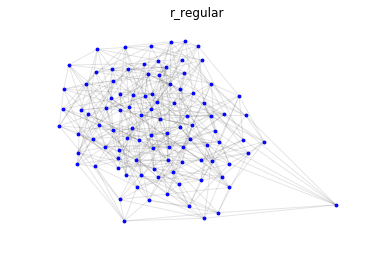

In [8]:
G_r = nx.from_numpy_matrix(A_r)

# create the layout
pos = nx.spring_layout(G_r)
# draw the nodes and the edges
nx.draw_networkx_nodes(G_r,pos,node_color='b',node_size=8)
nx.draw_networkx_edges(G_r,pos,alpha=0.1)
plt.title("r_regular")
plt.axis('off')
plt.show()

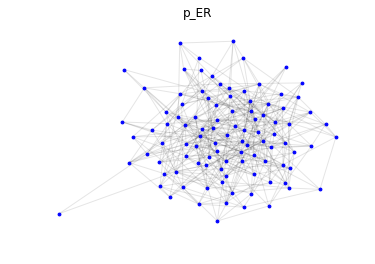

In [9]:
G_p = nx.from_numpy_matrix(A_p)

# create the layout
pos = nx.spring_layout(G_p)
# draw the nodes and the edges
nx.draw_networkx_nodes(G_p,pos,node_color='b',node_size=8)
nx.draw_networkx_edges(G_p,pos,alpha=0.1)
plt.title("p_ER")
plt.axis('off')
plt.show()

### Point 4: Compare the complexity as a function of n of the is.irreducible, L_method and BFS

In [10]:
# Vector of different n
n_vect = [50, 75, 100, 125, 150, 175, 200]

d_r = {}
for n in n_vect:
    d_r[n] = []
    
    # Generate an r_regular adjacency matrix
    A_r = r_regular(n, r)
    
    # Tests irreducibility method
    start = time.time()
    is_irreducible(A_r)
    d_r[n].append( time.time() - start )
    
    # Tests Laplacian eigenvalue method
    start = time.time()
    L_method(A_r)
    d_r[n].append( time.time() - start )
    
    # Tests BFS method
    start = time.time()
    BFS(A_r)
    d_r[n].append( time.time() - start )

Check time that each method needs

In [11]:
d_p = {}
for n in n_vect:
    d_p[n] = []
    
    # Generate an r_regulare adjacency matrix
    A_p = p_ER(n, p)
    
    # Tests irreducibility method
    start = time.time()
    is_irreducible(A_p)
    d_p[n].append( time.time() - start )
    
    # Tests Laplacian eigenvalue method
    start = time.time()
    L_method(A_p)
    d_p[n].append( time.time() - start )
    
    # Tests BFS method
    start = time.time()
    BFS(A_p)
    d_p[n].append( time.time() - start )

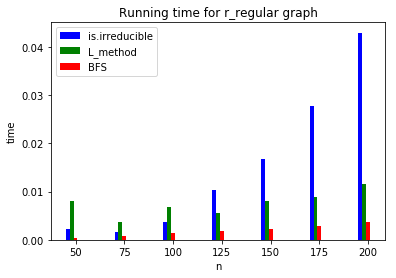

In [12]:
# Plot of the running time taken for the three different methods r_regular
colors = ['b', 'g', 'r']  
x, y = zip(*sorted(d_r.items(), key = lambda x: x[0]))

plt.figure()
for i in range(3):
    x = list(x)
    lst = []
    for h in range(len(y)):
        lst.append(y[h][i])
    
    for j in range(len(x)):
        x[j] = x[j]+2
        
    plt.bar(list(x), lst, color = colors[i], lw = 2, width = 2)
plt.legend(['is.irreducible', 'L_method', 'BFS'], loc = 2)
plt.title('Running time for r_regular graph')
plt.xlabel('n')
plt.ylabel('time')
plt.xticks(x, n_vect)
plt.show()

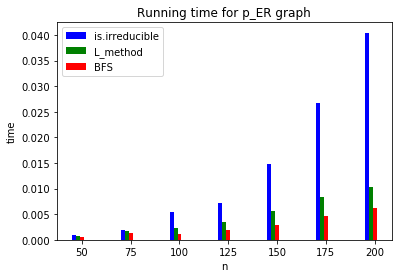

In [13]:
# Plot of the running time taken for the three different methods for p_ER
colors = ['b', 'g', 'r']  
z, k = zip(*sorted(d_p.items(), key = lambda x: x[0]))

plt.figure()
for i in range(3):
    z = list(z)
    lst = []
    for h in range(len(k)):
        lst.append(k[h][i])
    
    for j in range(len(z)):
        z[j] = z[j]+2
        
    plt.bar(list(z), lst, color = colors[i], lw = 2, width = 2)
plt.legend(['is.irreducible', 'L_method', 'BFS'], loc = 2)
plt.title('Running time for p_ER graph')
plt.xlabel('n')
plt.ylabel('time')
plt.xticks(z, n_vect)
plt.show()

### Point 5: Probability that a graph is connected


In [14]:
# Probability for a p_ER graph
rep = 100
p_vect = [i/100 for i in range(0,11)]
p_vect = p_vect + [i/10 for i in range(2,11)]
percent = []
for p in p_vect:
    count_p = 0
    for i in range(rep):
        
        A_p = p_ER(n, p)
        
        x = BFS(A_p)
        
        if( x == 'The graph is connected!' ):
            count_p += 1
    percent.append(count_p)
    print('The graph is connected the', count_p, '% of the time with p = ', p)

The graph is connected the 0 % of the time with p =  0.0
The graph is connected the 0 % of the time with p =  0.01
The graph is connected the 2 % of the time with p =  0.02
The graph is connected the 67 % of the time with p =  0.03
The graph is connected the 94 % of the time with p =  0.04
The graph is connected the 100 % of the time with p =  0.05
The graph is connected the 100 % of the time with p =  0.06
The graph is connected the 100 % of the time with p =  0.07
The graph is connected the 100 % of the time with p =  0.08
The graph is connected the 100 % of the time with p =  0.09
The graph is connected the 100 % of the time with p =  0.1
The graph is connected the 100 % of the time with p =  0.2
The graph is connected the 100 % of the time with p =  0.3
The graph is connected the 100 % of the time with p =  0.4
The graph is connected the 100 % of the time with p =  0.5
The graph is connected the 100 % of the time with p =  0.6
The graph is connected the 100 % of the time with p =  

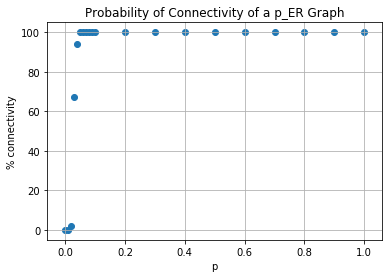

In [15]:
plt.scatter(p_vect,percent)
plt.title('Probability of Connectivity of a p_ER Graph')
plt.xlabel('p')
plt.ylabel('% connectivity')
plt.grid()
plt.show()

In [24]:
# Probability for a r_regular graph
#r_vect = [2, 4, 8, 16]
r_vect = [2, 4, 8]
n_vect = [i*10 for i in range(1,11)]
x_ax = []
y_ax = []
z_ax = []
for r in r_vect:
    for n in n_vect:
        count = 0
        for i in range(rep):
            
            A_r = r_regular(n, r)
            
            x = BFS(A_r)
            
            if( x == 'The graph is connected!' ):
                count += 1
        print('For n =', n, 'and r =',  r, 'the graph is connected the', count, '% of the time')
        x_ax.append(r)
        y_ax.append(n)
        z_ax.append(count)

For n = 10 and r = 2 the graph is connected the 51 % of the time
For n = 20 and r = 2 the graph is connected the 50 % of the time
For n = 30 and r = 2 the graph is connected the 38 % of the time
For n = 40 and r = 2 the graph is connected the 36 % of the time
For n = 50 and r = 2 the graph is connected the 30 % of the time
For n = 60 and r = 2 the graph is connected the 29 % of the time
For n = 70 and r = 2 the graph is connected the 20 % of the time
For n = 80 and r = 2 the graph is connected the 16 % of the time
For n = 90 and r = 2 the graph is connected the 25 % of the time
For n = 100 and r = 2 the graph is connected the 17 % of the time
For n = 10 and r = 4 the graph is connected the 100 % of the time
For n = 20 and r = 4 the graph is connected the 100 % of the time
For n = 30 and r = 4 the graph is connected the 100 % of the time
For n = 40 and r = 4 the graph is connected the 100 % of the time
For n = 50 and r = 4 the graph is connected the 100 % of the time
For n = 60 and r = 

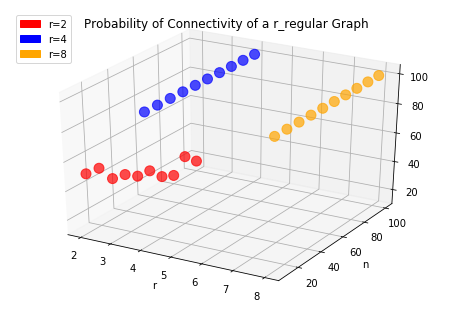

In [52]:

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_ax, y_ax, z_ax, s=100,alpha=0.7,c=['red','red','red','red','red','red','red','red','red','red',"blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","orange","orange","orange","orange","orange","orange","orange","orange","orange","orange"])
plt.title('Probability of Connectivity of a r_regular Graph')
plt.xlabel('r')
plt.ylabel('n')
r2 = mpatches.Patch(color='red', label='r=2')
r4 = mpatches.Patch(color='blue', label='r=4')
r8 = mpatches.Patch(color='orange', label='r=8')

plt.legend(handles=[r2,r4,r8],loc=2)
plt.show()

#  PART 2

### 1

In [16]:
def weight_dict(graph):
    '''Create a dictionary that contains for each node of the graph all the linked nodes and their weigths'''

    # Define the list where will be stored data
    lst_tot=[]
    for xx in graph.nodes(): 
        for yy in graph[xx]:
            # Save the weigth between node xx and node yy
            lst=(xx,yy,graph[xx][yy]["weight"])
            lst_tot.append(lst)
        
    # Store the information obtained previously in a dictionary       
    g = defaultdict(list)

    for node1,node2,weight in lst_tot:
        g[node1].append((weight,node2))    
    
    return g

In [17]:
def dijkstra(g, start):
    '''Create a function that return for a node in input (start) the shortest path for all the nodes that have path with the starting one'''
    maw = {}
    # Inizialize q
    q = [(0,start,())] 
    # Inizialize the seen variable empty. It will be update with the seen nodes
    seen=set()
    while q:
        # Pop the smaller element of q
        (cost,v1,path) = heappop(q)
        
        
        # If the selected node is not already seen, we will execute the following commands
        if v1 not in seen:
            # Add the current node to the seen
            seen.add(v1)
            path = (*path, v1)
            
            # For node v1 get all the neighbour
            for c, v2 in g.get(v1, ()):
                # Check if v2 is not an already seen node
                if v2 not in seen:
                    
                    heappush(q, (cost+c, v2,path))
            
            maw[v1] = [cost,path]
    return (maw)

In [22]:
# Create a list with different sizes (number of nodes)
n_vect = [i*10 for i in range(1,11)]

# Initialize empty list
h_r_list = []
h_p_list = []
TH_r_list = []
TH_p_list = []

# Iterate over the different sizes
for n in n_vect:
    
    # Create a graph for each different n (number of nodes)
    p = 8/(n-1)               
    r = 8
    
    A_r = r_regular(n, r)
    m_r = n*r/2
    print("For r_regular with ",n," nodes, the number of edges is: ", round(m_r,0))
    
    A_p = p_ER(n, p)
    m_p = p*n*(n-1)/2
    print("For p_ER with ",n," nodes, the number of edges is: ", round(m_p,0))
    
    v_f = n*(n-1)/2
    
    x = BFS(A_p)
    y = BFS(A_r)
    
    # Create a graph from the adjency matrix
    G_r = nx.from_numpy_matrix(A_r)
    G_p = nx.from_numpy_matrix(A_p)
    
    # Create a distance dictionary from the graph
    w_r = weight_dict(G_r)
    w_p = weight_dict(G_p)
    
    # Evaluate the shortest path between all the pairs of nodes in the graph
    shortest_path_r = {}
    for node_1 in range(n):
        # Evaluate the dijkstra for a certain node
        aux = dijkstra(w_r,node_1)
        for node_2 in aux:
            if node_1 != node_2:
                shortest_path_r[(node_1,node_2)] = aux[node_2]
    
    # Evaluate the average length of the shortest path between all the pairs of nodes
    h_r = sum([cost[0] for cost in shortest_path_r.values()])/len(shortest_path_r)
    h_r_list.append(h_r)
    
    TH_r = m_r/(v_f*h_r)
    TH_r_list.append(TH_r)
    
    # Evaluate the same quantities for the p-regular random graph
    shortest_path_p = {}
    for node_1 in range(n):
        aux = dijkstra(w_p,node_1)
        for node_2 in aux:
            if node_1 != node_2:
                shortest_path_p[(node_1,node_2)] = aux[node_2]
    
    h_p = sum([cost[0] for cost in shortest_path_p.values()])/len(shortest_path_p)
    h_p_list.append(h_p)
    
    TH_p = m_p/(v_f*h_p)
    TH_p_list.append(TH_p)


For r_regular with  10  nodes, the number of edges is:  40.0
For p_ER with  10  nodes, the number of edges is:  40.0
For r_regular with  20  nodes, the number of edges is:  80.0
For p_ER with  20  nodes, the number of edges is:  80.0
For r_regular with  30  nodes, the number of edges is:  120.0
For p_ER with  30  nodes, the number of edges is:  120.0
For r_regular with  40  nodes, the number of edges is:  160.0
For p_ER with  40  nodes, the number of edges is:  160.0
For r_regular with  50  nodes, the number of edges is:  200.0
For p_ER with  50  nodes, the number of edges is:  200.0
For r_regular with  60  nodes, the number of edges is:  240.0
For p_ER with  60  nodes, the number of edges is:  240.0
For r_regular with  70  nodes, the number of edges is:  280.0
For p_ER with  70  nodes, the number of edges is:  280.0
For r_regular with  80  nodes, the number of edges is:  320.0
For p_ER with  80  nodes, the number of edges is:  320.0
For r_regular with  90  nodes, the number of edges i

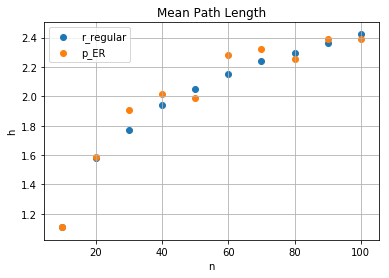

In [19]:
plt.scatter(n_vect,h_r_list)
plt.scatter(n_vect,h_p_list)
plt.legend(('r_regular', 'p_ER'))
plt.title('Mean Path Length')
plt.xlabel('n')
plt.ylabel('h')
plt.grid()
plt.show()

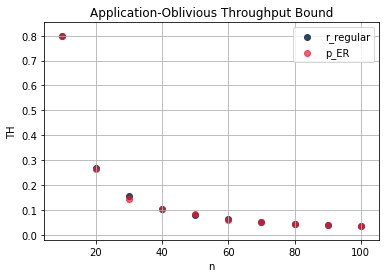

In [20]:
plt.scatter(n_vect,TH_r_list,color=(0.1,0.2,0.3,0.9))
plt.scatter(n_vect,TH_p_list,color=(0.9,0.1,0.2,0.7))
plt.legend(('r_regular', 'p_ER'))
plt.title('Application-Oblivious Throughput Bound')
plt.xlabel('n')
plt.ylabel('TH')
plt.grid()
plt.show()

### Point 2: Plot TH as a function of q for 0 < q ≤ 0.25, for the two network models in point 1) above.

In [33]:
def delete_edge(g, q = 0, n = 100):
    # Initialize a copy of the adjacency matrix
    mat = g.copy()
    # Cycle over the nonzero of the upper triangular matrix
    for i,j in zip(*np.nonzero(np.triu(mat))): 
        if(np.random.binomial(1, 1-q, 1)[0] == 0): # Probability of breaking an edge
            mat[i, j] = 0
            mat[j, i] = 0
    
    G = nx.from_numpy_matrix(mat)
    w = weight_dict(G)
    
    shortest_path = {}
    for node_1 in range(n):
        aux = dijkstra(w,node_1)
        for node_2 in aux:
            if node_1 != node_2:
                shortest_path[(node_1,node_2)] = aux[node_2]
    return(shortest_path)

In [34]:
n = 100    
p = 8/(n-1)               
r = 8

A_r = r_regular(n, r)
A_p = p_ER(n, p)


probs = np.arange(0.01, 0.26, 0.01) # Sets probabilities
  
# Compute the TH max for each different probability 
n_rep = 5
TH_r_vect = {}
TH_p_vect = {}
for q in probs:
    q = round(q,2)
    print('Computing TH for probability:', q)
    TH_r_vect[q] = 0
    TH_p_vect[q] = 0
    
    for rep in range(n_rep):
        print('Simulation #', rep)
        del_path_r = delete_edge(A_r, q, n)
        del_path_p = delete_edge(A_p, q, n)
        
        v_f = n*(n-1)/2
        m_r = n*r/2
        m_p = p*n*(n-1)/2
        
        h_r = sum([cost[0] for cost in del_path_r.values()])/len(del_path_r)
        h_p = sum([cost[0] for cost in del_path_p.values()])/len(del_path_p)
    
        TH_r = m_r/(v_f*h_r)
        TH_p = m_p/(v_f*h_p)
        
        TH_r_vect[q] += TH_r/n_rep
        TH_p_vect[q] += TH_p/n_rep

Computing TH for probability: 0.01
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing TH for probability: 0.02
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing TH for probability: 0.03
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing TH for probability: 0.04
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing TH for probability: 0.05
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing TH for probability: 0.06
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing TH for probability: 0.07
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing TH for probability: 0.08
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing TH for probability: 0.09
Simulation # 0
Simulation # 1
Simulation # 2
Simulation # 3
Simulation # 4
Computing 

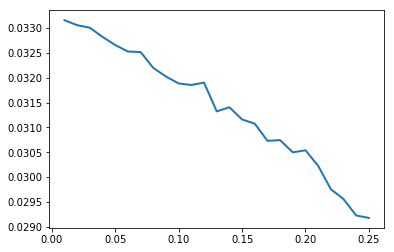

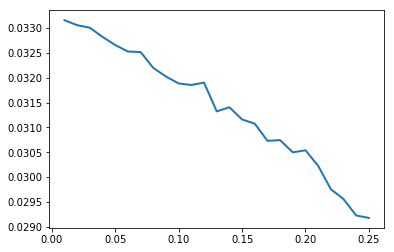

In [36]:
plt.figure()
x,y = zip(*sorted(TH_r_vect.items(), key = lambda x: x[0]))
plt.plot(x, y, lw = 2)
z,k = zip(*sorted(TH_p_vect.items(), key = lambda x: x[0]))
plt.plot(z, k, lw = 2)
plt.title('TH performance of r-regular vs p-ER random graphs')
plt.xlabel('probability of a link to break down')
plt.ylabel('TH value')
plt.legend(['r-regular', 'p-ER'], loc = 1)
plt.grid()
plt.show()